In [4]:
# Note, this requires cloning the facenet_pytorch repo
from facenet_pytorch import MTCNN
import numpy as np
import cv2
import matplotlib.pyplot as plt

def detect_face(img):
    mtcnn = MTCNN(keep_all=True, device=device)
    return mtcnn.detect(img)

def mask_face(img, x1, x2, y1, y2):
    print('mask for mask_face')
    print((x1, x2, y1, y2))
    h,w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[y1:y2,x1:x2] = 1 #np.random.rand(y2-y1, x2-x1, 3) * 255
    masked_image = img.copy()
    masked_image[y1:y2,x1:x2] = 1
    
    wider_x_adj = 30
    wider_y_adj = 30

    # Create the wider rectangular region
    wider_x1 = max(0, x1 - wider_x_adj)
    wider_x2 = min(img.shape[1], x2 + wider_x_adj)
    wider_y1 = max(0, y1 - wider_y_adj)
    wider_y2 = min(img.shape[0], y2 + wider_y_adj)
    
    h,w, _ = img[wider_y1:wider_y2,wider_x1:wider_x2].shape
    cropped_mask = np.zeros((h, w), dtype=np.uint8)
    cropped_mask[y1:y2,x1:x2] = 1
    
    return mask, masked_image, img[wider_y1:wider_y2,wider_x1:wider_x2], cropped_mask

def mask_detected_faces(input_face_path='CS445-Object-Inpainting/data_faces/joe_face_small.jpeg'):
    frame = cv2.cvtColor(cv2.imread(input_face_path), cv2.COLOR_BGR2RGB)
    
    boxes, confidence = detect_face(frame)

    masked = frame.copy()

    for i, detected in enumerate(boxes):
        if confidence[i] < .5:
            continue

        [x1, y1, x2, y2] = detected
        

        
        
        # adjust mask smaller so face replacement has more to work with
        x_adj = abs(x2-x1) / 8
        y_adj = abs(y2-y1) / 8
        x1 = int(x1 + x_adj)
        x2 = int(x2 - x_adj)
        y1 = int(y1 + y_adj)
        y2 = int(y2 - y_adj)
        
        mask, masked_image, frame_for_generate, frame_for_generate_mask = mask_face(masked, x1, x2, y1, y2)     
    print('detect face image')
    plt.imshow(masked_image)
    plt.show()
    return frame, mask, frame_for_generate, frame_for_generate_mask

In [5]:
import torch
from utils.models import GatedGenerator, Generator, Discriminator

def load_checkpoint(generator, discriminator_local, discriminator_global, path, device):
    state = torch.load(path,map_location=device)
    generator.load_state_dict(state['G'])
    discriminator_global.load_state_dict(state['D_G'])
    discriminator_local.load_state_dict(state['D_L'])
    print('Loaded checkpoint successfully')
    return generator, discriminator_local, discriminator_global



In [6]:
device = 'cuda:2'
generator = GatedGenerator()
discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)

In [7]:
generator, discriminator_local, discriminator_global = load_checkpoint(generator, discriminator_local, discriminator_global, "/home/x1112373/CS445-Object-Inpainting/model_trained/model_1.pth", device)

Loaded checkpoint successfully


In [8]:
generator.eval()

GatedGenerator(
  (coarse): Sequential(
    (0): GatedConv2d(
      (pad): ZeroPad2d((3, 3, 3, 3))
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
      (mask_conv2d): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
      (sigmoid): Sigmoid()
    )
    (1): GatedConv2d(
      (pad): ZeroPad2d((1, 1, 1, 1))
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (mask_conv2d): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (sigmoid): Sigmoid()
    )
    (2): GatedConv2d(
      (pad): ZeroPad2d((1, 1, 1, 1))
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(128, 256, kernel_size=(3, 3)

In [9]:
def resize_image(img, blocks=(128, 128)):
    transposed_image = img.transpose(2, 0, 1)
    resized_image = []
    for channel in transposed_image:
        resized_channel = cv2.resize(channel, blocks, interpolation=cv2.INTER_AREA)
        resized_image.append(resized_channel)
    img = np.array(resized_image)
    return img

In [26]:
from torchvision.transforms import ToTensor
import random

def random_block_mask(image, block_size=(32,32)):
    h, w, _ = image.shape
    x = random.randint(0, w - block_size[0]*2)
    y = random.randint(0, h - block_size[1]*2)
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[y:y + block_size[1], x:x + block_size[0]] = 1
    masked_image = image.copy()
    noise = np.random.randint(0, 256, size=(block_size[1], block_size[0], 3), dtype=np.uint8)
    masked_image[y:y + block_size[1], x:x + block_size[0]] = noise
    return masked_image, mask


def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)

mask for mask_face
(137, 212, 80, 192)
detect face image


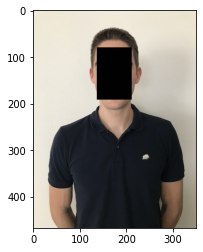

In [32]:
## detect face part
frame, _, frame_for_generate, frame_for_generate_mask = mask_detected_faces()
frame_for_generate = resize_image(frame_for_generate)
frame = resize_image(frame)
masked_image, masked = random_block_mask(frame_for_generate.transpose(1,2,0), block_size=(32,32))

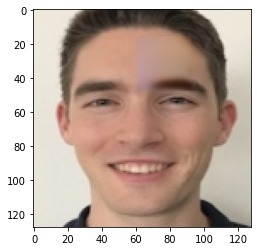

In [33]:
frame_for_generate = torch.from_numpy(frame_for_generate).unsqueeze(0) 
masked = torch.tensor(masked, dtype=torch.float32).unsqueeze(0).unsqueeze(0) 
 
frame_for_generate = frame_for_generate.to(device)
masked = masked.to(device)
first_out, second_out  = generator(frame_for_generate/255, masked)

first_out_wholeimg = frame_for_generate/255 * (1 - masked ) + first_out * masked     
second_out_wholeimg = frame_for_generate/255 * (1 - masked ) + second_out * masked 
resized_final_image = []
for channel in second_out_wholeimg[0]:
    resized_channel = cv2.resize(channel.detach().cpu().numpy(), (128, 128))
    resized_final_image.append(resized_channel)
resized_final_image = np.array(resized_final_image)    
plt.imshow(resized_final_image.transpose(1,2,0))

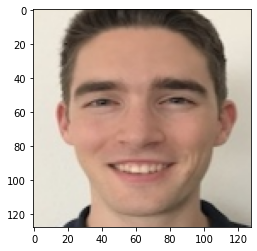

In [34]:
#frame_for_generate = torch.from_numpy(frame_for_generate).unsqueeze(0) 
plt.imshow(return_image_numpy(frame_for_generate/255    ))

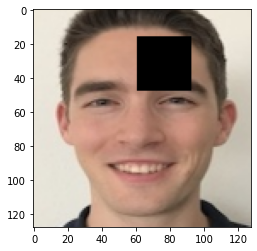

In [35]:
plt.imshow(return_image_numpy(frame_for_generate/255 * (1 - masked )))

mask for mask_face
(137, 212, 80, 192)
detect face image


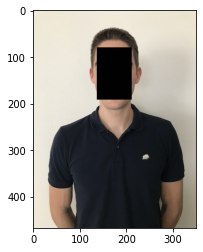

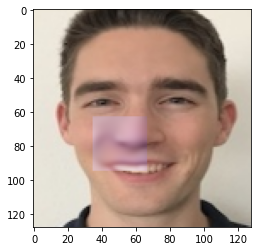

In [36]:
## detect face part
frame, _, frame_for_generate, frame_for_generate_mask = mask_detected_faces()
frame_for_generate = resize_image(frame_for_generate)
frame = resize_image(frame)
masked_image, masked = random_block_mask(frame_for_generate.transpose(1,2,0), block_size=(32,32))

frame_for_generate = torch.from_numpy(frame_for_generate).unsqueeze(0) 
masked = torch.tensor(masked, dtype=torch.float32).unsqueeze(0).unsqueeze(0) 
 
frame_for_generate = frame_for_generate.to(device)
masked = masked.to(device)
first_out, second_out  = generator(frame_for_generate/255, masked)

first_out_wholeimg = frame_for_generate/255 * (1 - masked ) + first_out * masked     
second_out_wholeimg = frame_for_generate/255 * (1 - masked ) + second_out * masked 
resized_final_image = []
for channel in second_out_wholeimg[0]:
    resized_channel = cv2.resize(channel.detach().cpu().numpy(), (128, 128))
    resized_final_image.append(resized_channel)
resized_final_image = np.array(resized_final_image)    
plt.imshow(resized_final_image.transpose(1,2,0))